In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-11-05 16:36:29.957200: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-05 16:36:30.254581: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 16:36:30.254636: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 16:36:30.256398: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 16:36:30.392511: I tensorflow/core/platform/cpu_feature_g

In [2]:
!ls vehicle_classify/training_images/ambulance

'image (10).jpeg'    'images (1).jpeg'	  'images (326).jpeg'
'image (11).jpeg'    'images (200).jpeg'  'images (327).jpeg'
'image (12).jpeg'    'images (201).jpeg'  'images (328).jpeg'
'image (13).jpeg'    'images (202).jpeg'  'images (329).jpeg'
'image (14).jpeg'    'images (203).jpeg'  'images (32).jpeg'
'image (15).jpeg'    'images (204).jpeg'  'images (330).jpeg'
'image (16).jpeg'    'images (205).jpeg'  'images (331).jpeg'
'image (17).jpeg'    'images (206).jpeg'  'images (332).jpeg'
'image (18).jpeg'    'images (207).jpeg'  'images (333).jpeg'
'image (19).jpeg'    'images (208).jpeg'  'images (334).jpeg'
'image (20).jpeg'    'images (209).jpeg'  'images (335).jpeg'
'image (21).jpeg'    'images (20).jpeg'   'images (336).jpeg'
'image (22).jpeg'    'images (210).jpeg'  'images (337).jpeg'
'image (23).jpeg'    'images (211).jpeg'  'images (338).jpeg'
'image (24).jpeg'    'images (212).jpeg'  'images (339).jpeg'
'image (25).jpeg'    'images (213).jpeg'  'images (33).jpeg'
'image (26)

In [2]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "vehicle_classify/training_images/",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 419 files belonging to 1 classes.


Using 336 files for training.
Using 83 files for validation.


2023-11-05 16:36:41.147651: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


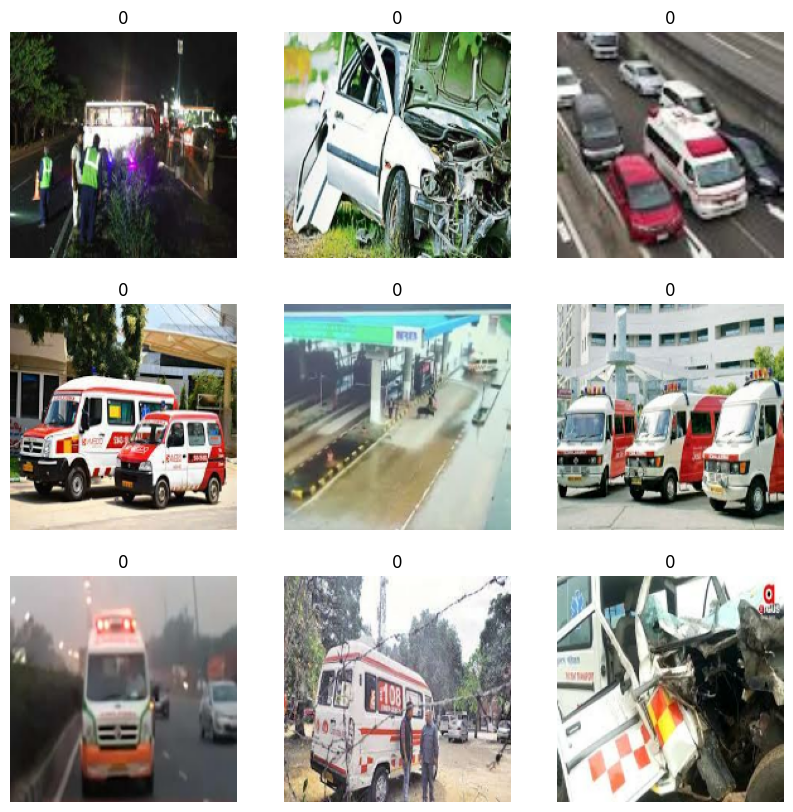

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [3]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

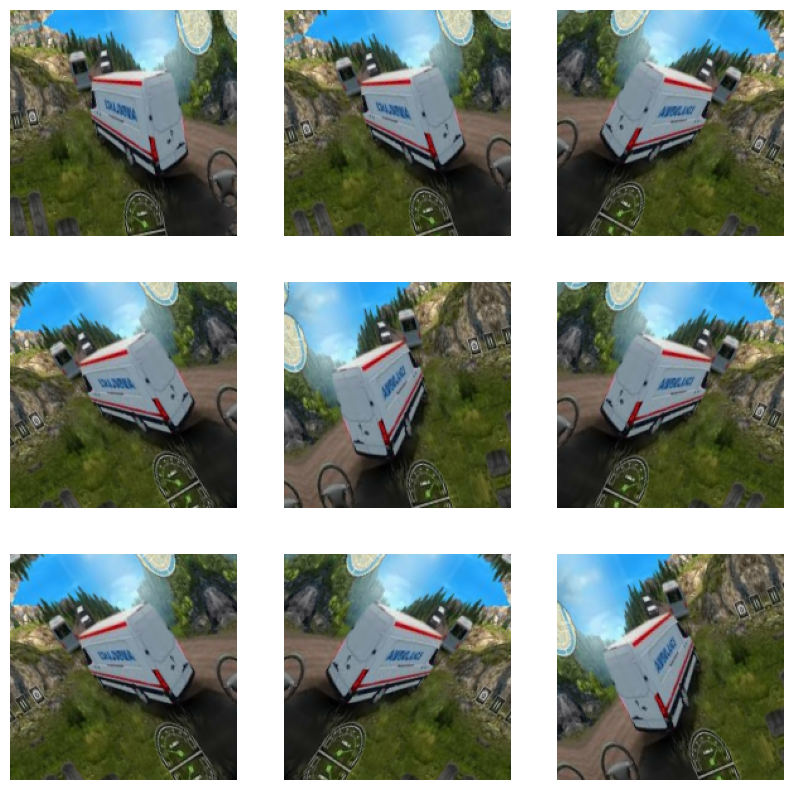

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [4]:
rescale = tf.keras.layers.Rescaling(1.0/255.0)

dataset = tf.keras.utils.image_dataset_from_directory("vehicle_classify/training_images/")

dataset = dataset.map(lambda x, y: (rescale(x), y))

Found 419 files belonging to 1 classes.


In [5]:
augmented_train_ds = train_ds.map(
    lambda x, y:(data_augmentation(x, training=True), y)
)

In [6]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x 

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=1)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
epochs = 25

callback = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callback,
    validation_data=val_ds
)

Epoch 1/25
3/3 [==============================] - ETA: 0s - loss: 0.4830 - accuracy: 0.0000e+00 

2023-11-05 16:38:20.377871: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model_2/activation_21/Relu' exist for missing node 'model_2/add_6/add'.


3/3 [==============================] - 41s 12s/step - loss: 0.4830 - accuracy: 0.0000e+00 - val_loss: 0.6576 - val_accuracy: 0.0000e+00
Epoch 2/25
3/3 [==============================] - 54s 19s/step - loss: 0.1128 - accuracy: 0.0000e+00 - val_loss: 0.6297 - val_accuracy: 0.0000e+00
Epoch 3/25
3/3 [==============================] - 39s 11s/step - loss: 0.0373 - accuracy: 0.0000e+00 - val_loss: 0.6045 - val_accuracy: 0.0000e+00
Epoch 4/25
3/3 [==============================] - 34s 11s/step - loss: 0.0155 - accuracy: 0.0000e+00 - val_loss: 0.5817 - val_accuracy: 0.0000e+00
Epoch 5/25
3/3 [==============================] - 34s 11s/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.5594 - val_accuracy: 0.0000e+00
Epoch 6/25
3/3 [==============================] - 34s 11s/step - loss: 0.0053 - accuracy: 0.0000e+00 - val_loss: 0.5371 - val_accuracy: 0.0000e+00
Epoch 7/25
3/3 [==============================] - 34s 11s/step - loss: 0.0031 - accuracy: 0.0000e+00 - val_loss: 0.5150 - val_acc

In [1]:
!pip uninstall opencv-python-headless -y

Found existing installation: opencv-python-headless 4.8.1.78
Uninstalling opencv-python-headless-4.8.1.78:
  Successfully uninstalled opencv-python-headless-4.8.1.78


In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened():
    ret, frame = cap.read()
    image_np = np.array(frame)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)